# Topic Modeling with MALLET

For our topic modeling analysis, we're going to use a tool called [MALLET](http://mallet.cs.umass.edu/topics.php). MALLET, short for **MA**chine **L**earning for **L**anguag**E** **T**oolkit, is a software package for  topic modeling and other natural language processing techniques.

MALLET is great, but it's written in Java, another programming language. It also means that MALLET isn't typically ideal for Python and Jupyter notebooks.

Luckily, Maria Antoniak, whom we (virtually) met, has written a convenient Python package that will allow us to use MALLET in this Jupyter notebook. This package is called [Little MALLET Wrapper](https://github.com/maria-antoniak/little-mallet-wrapper).

Note: A "wrapper" is a Python package that makes complicated code easier to use and/or makes code from a different programming language accessible in Python.

## *New York Times* Obituaries

In this lesson, we're going to use [Little MALLET Wrapper](https://github.com/maria-antoniak/little-mallet-wrapper) to topic model 378 obituaries published by *The New York Times*. This dataset is based on data originally collected by Matt Lavin for his *Programming Historian* [TF-IDF tutorial](https://programminghistorian.org/en/lessons/analyzing-documents-with-tfidf#lesson-dataset). Melanie Walsh re-scraped the obituaries so that the subject's name and death year are included in each text file name; she also added 12 more ["Overlooked"](https://www.nytimes.com/interactive/2018/obituaries/overlooked.html) obituaries.

## Download MALLET

*Note: If you're working in this Jupyter notebook on your own computer, you'll need to install both the Java Development Kit and MALLET. For set up instructions, please see [this lesson](http://melaniewalsh.github.io/Intro-Cultural-Analytics/Text-Analysis/Topic-Modeling-Set-Up.html).*

If you're working on JupyterHub, then the Java Development Kit is already installed. You will still, however, need to install mallet. To do so follow these instructions:

1. Go to the [home page](http://ec2-35-153-110-194.compute-1.amazonaws.com/) of your JupyterHub
2. At the top right, click the box that says "New" and then select "Terminal."
3. In the terminal, type `wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.tar.gz` and press return.
4. In the terimal, type `tar -xf mallet-2.0.8.tar.gz`
5. Mallet should be installed! If you type `ls` it should show you the contents of your JupyterHub, including the new mallet folder which you've just created.


## Setup MALLET path 
Now we need to tell the little-mallet-wrapper where the bigger, Java-based MALLET lives.

We're going to make a variable called `path_to_mallet` and assign it the file path of our MALLET program. We need to point it, specifically, to the "mallet" file inside the "bin" folder inside the "mallet-2.0.8" folder.

In [16]:
path_to_mallet = '../mallet-2.0.8/bin/mallet'

If MALLET is located in another directory, then set your `path_to_mallet` to that file path.

## Install Packages

In [ ]:
# these are pre-installed in JupyterHub
#!pip install little_mallet_wrapper
#!pip install seaborn

## Import Packages

Now let's `import` the `little_mallet_wrapper` and the data viz library `seaborn`.

In [2]:
import little_mallet_wrapper
import seaborn
import glob
from pathlib import Path

We're also going to import [`glob`](https://docs.python.org/3/library/glob.html) and [`pathlib`](https://docs.python.org/3/library/pathlib.html#basic-use) for working with files and the file system.

## Get Training Data 

Before we topic model the *NYT* obituaries, we need to pre-process the text files to prepare them for analysis. 

```{note}
We're calling these text files our *training data*, because we're *training* our topic model with these texts. The topic model will be learning and extracting topics based on these texts.
```

To get the necessary text files, we're going to make a variable and assign it the file path for the directory that contains the text files. 

_If the below line doesn't work, you might need to [download](https://canvas.emory.edu/courses/76593/files/4268875?module_item_id=1056761) the files from Canvas and direct to the path where it lives_

In [3]:
directory = "../QTM340-Fall21/corpora/NYT-Obituaries/"

Then we're going to use the `glob.gob()` function to make a list of all (`*`) the `.txt` files in that directory.

In [4]:
files = glob.glob(f"{directory}/*.txt")

In [5]:
files

['../QTM340-Fall21/corpora/NYT-Obituaries/1994-Jacqueline-Kennedy.txt',
 '../QTM340-Fall21/corpora/NYT-Obituaries/1955-Walter-White.txt',
 '../QTM340-Fall21/corpora/NYT-Obituaries/1907-Qiu-Jin.txt',
 '../QTM340-Fall21/corpora/NYT-Obituaries/1994-Linus-C-Pauling.txt',
 '../QTM340-Fall21/corpora/NYT-Obituaries/1919-Carnegie-Started.txt',
 '../QTM340-Fall21/corpora/NYT-Obituaries/1926-Harry-Houdini.txt',
 '../QTM340-Fall21/corpora/NYT-Obituaries/1959-Ross-G-Harrison.txt',
 '../QTM340-Fall21/corpora/NYT-Obituaries/1954-Enrico-Fermi.txt',
 '../QTM340-Fall21/corpora/NYT-Obituaries/1928-Mabel-Craty.txt',
 '../QTM340-Fall21/corpora/NYT-Obituaries/1954-Getulio-Vargas.txt',
 '../QTM340-Fall21/corpora/NYT-Obituaries/1993-Arthur-Ashe.txt',
 '../QTM340-Fall21/corpora/NYT-Obituaries/1971-Dean-Acheson.txt',
 '../QTM340-Fall21/corpora/NYT-Obituaries/1980-Jean-Piaget.txt',
 '../QTM340-Fall21/corpora/NYT-Obituaries/1975-Chiang-Kai-shek.txt',
 '../QTM340-Fall21/corpora/NYT-Obituaries/1982-Ingrid-Bergman.

## Preprocessing

Next we process our texts with the function `little_mallet_wrapper.process_string()`. This function will take every individual text file, transform all the text to lowercase as well as remove stopwords, punctuation, and numbers, and then add the processed text to our master list `training_data`.

Python Review!
Take a moment to study this code and reflect about what's happening here. This is a very common Python pattern! We make an empty list, iterate through every file, open and read each text file, process the texts, and finally append them to the previously empty list.

In [17]:
training_data = []
for file in files:
    text = open(file, encoding='utf-8').read()
    processed_text = little_mallet_wrapper.process_string(text, numbers='remove')
    training_data.append(processed_text)

We're also making a master list of the original text of the obituaries for future reference.

In [7]:
original_texts = []
for file in files:
    text = open(file, encoding='utf-8').read()
    original_texts.append(text)

## Process Titles

Here we extract the relevant part of each file name by using [`Path().stem`](https://docs.python.org/3/library/pathlib.html#pathlib.PurePath.stem), which conveniently extracts just the last part of the file path without the ".txt" file extension. Because each file name includes the obituary subject's name as well as the year that the subject died, we're going to use this information as a title or label for each obituary.

In [8]:
obit_titles = [Path(file).stem for file in files]

In [9]:
obit_titles

['1994-Jacqueline-Kennedy',
 '1955-Walter-White',
 '1907-Qiu-Jin',
 '1994-Linus-C-Pauling',
 '1919-Carnegie-Started',
 '1926-Harry-Houdini',
 '1959-Ross-G-Harrison',
 '1954-Enrico-Fermi',
 '1928-Mabel-Craty',
 '1954-Getulio-Vargas',
 '1993-Arthur-Ashe',
 '1971-Dean-Acheson',
 '1980-Jean-Piaget',
 '1975-Chiang-Kai-shek',
 '1982-Ingrid-Bergman',
 '1979-Stan-Kenton',
 '1960-Beno-Gutenberg',
 '1971-Khrushchev',
 '1953-Joseph-Stalin',
 '1947-Willa-Cather',
 '1982-Thelonious-Monk',
 '1901-Queen-Victoria',
 '1966-Chester-Nimitz',
 '1910-Tolstoy',
 '1973-Eddie-Rickenbacker',
 '1966-Walt-Disney',
 '1972-J-Edgar-Hoover',
 '1993-Albert-Sabin',
 '1969-Mies-van-der-Rohe',
 '1885-Ulysses-Grant',
 '1966-Lenny-Bruce',
 '1987-Clare-Boothe-Luce',
 '1970-Edouard-Daladier',
 '1961-Primitive-Artist',
 '1983-Jack-Dempsey',
 '1968-Martin-Luther-King-Jr',
 '1993-Cesar-Chavez',
 '1989-Andrei-A-Gromyko',
 '1939-W-B-Yeats',
 '1995-Jonas-Salk',
 '1998-Frank-Sinatra',
 '1989-Andrei-Sakharov',
 '1945-Jerome-Kern',


## Get Training Data Stats

We can get training data summary statistics by using the function ```little_mallet_wrapper.print_dataset_stats()```.

In [10]:
little_mallet_wrapper.print_dataset_stats(training_data)

Number of Documents: 378
Mean Number of Words per Document: 1316.5
Vocabulary Size: 35955


According to this little report, we have 378 documents (or obituaries) that average 1316.5 words in length.

## Training the Topic Model

We're going to train our topic model with the `little_mallet_wrapper.train_topic_model()` function. As you can see above, however, this function requires 6 different arguments and file paths to run properly. 

### Set Number of Topics

We need to make a variable `num_topics` and assign it the number of topics we want returned.

In [12]:
num_topics = 10

### Set Training Data

We already made a variable called `training_data`, which includes all of our processed obituary texts, so we can just set it equal to itself.

In [13]:
training_data = training_data

### Set Topic Model Output Files

Finally, we need to tell Little MALLET Wrapper where to find and output all of our topic modeling results. The code below will set Little MALLET Wrapper up to output your results inside a directory called "topic-model-output" and a subdirectory called "NYT-Obits", all of which will be inside your current directory.

If you'd like to change this output location, simply change `output_directory_path` below.

In [21]:
#Change to your desired output directory
output_directory_path = 'topic-model-output/NYT-Obits'

#No need to change anything below here
Path(f"{output_directory_path}").mkdir(parents=True, exist_ok=True)

path_to_training_data           = f"{output_directory_path}/training.txt"
path_to_formatted_training_data = f"{output_directory_path}/mallet.training"
path_to_model                   = f"{output_directory_path}/mallet.model.{str(num_topics)}"
path_to_topic_keys              = f"{output_directory_path}/mallet.topic_keys.{str(num_topics)}"
path_to_topic_distributions     = f"{output_directory_path}/mallet.topic_distributions.{str(num_topics)}"
path_to_diagnostics             = f"{output_directory_path}/diagnostics.xml"
path_to_word_weights            = f"{output_directory_path}/word.weights"

### Import Data

Now we import our training data with `little_mallet_wrapper.import_data()`.

In [19]:
little_mallet_wrapper.import_data(path_to_mallet,
                path_to_training_data,
                path_to_formatted_training_data,
                training_data)

Importing data...
Complete


### Train Topic Model

Finally, we train our topic model with `little_mallet_wrapper.train_topic_model()`. The topic model should take about 45 seconds to 1 minute to fully train and complete. If you want, you can look at your Terminal or PowerShell while it's running and see what the model looks like as it trains.

In [22]:
little_mallet_wrapper.train_topic_model(path_to_mallet,
                      path_to_formatted_training_data,
                      path_to_model,
                      path_to_topic_keys,
                      path_to_topic_distributions,
                      path_to_word_weights,
                      path_to_diagnostics,
                      num_topics)

Training topic model...


Mallet LDA: 10 topics, 4 topic bits, 1111 topic mask
Data loaded.
max tokens: 19800
total tokens: 497642
<10> LL/token: -10.02457
<20> LL/token: -9.70448
<30> LL/token: -9.59392
<40> LL/token: -9.53124

0	0.5	general united war states army time king american gen secretary took made policy later president military peace washington chief nations 
1	0.5	life new wrote years work miss book many one published later time american story york books women art woman writing 
2	0.5	said first one made company years man called never business old came john two chicago new father get york great 
3	0.5	mrs said one men would death people home day white last went kennedy much south times see old two national 
4	0.5	soviet one would could grant time union life long great mao day end communist never party china world also sent 
5	0.5	president state party political government roosevelt new court first house years public said congress leader many justice became truman campaign 
6	0.5	miss film played pla

Complete


When the topic model finishes, it will output your results to your `output_directory_path`.

## Display Topics and Top Words

To examine the 10 topics that the topic model extracted from the *NYT* obituaries, run the cell below. This code uses the `little_mallet_wrapper.load_topic_keys()` function to read and process the MALLET topic model output from your computer, specifically the file "mallet.topic_keys.10".

>*Take a minute to read through every topic. Reflect on what each topic seems to capture as well as how well you think the topics capture the broad themes of the entire collection. Note any oddities, outliers, or inconsistencies.*

In [23]:
topics = little_mallet_wrapper.load_topic_keys(path_to_topic_keys)

for topic_number, topic in enumerate(topics):
    print(f"✨Topic {topic_number}✨\n\n{topic}\n")

✨Topic 0✨

['general', 'gen', 'grant', 'army', 'war', 'israel', 'president', 'military', 'peace', 'men', 'secretary', 'arab', 'pershing', 'command', 'israeli', 'troops', 'upon', 'macarthur', 'forces', 'union']

✨Topic 1✨

['miss', 'book', 'wrote', 'published', 'life', 'writing', 'books', 'author', 'writer', 'new', 'novel', 'said', 'mrs', 'york', 'work', 'story', 'magazine', 'stories', 'literary', 'read']

✨Topic 2✨

['company', 'business', 'times', 'york', 'louis', 'new', 'ford', 'ochs', 'news', 'paper', 'oil', 'rockefeller', 'pulitzer', 'newspaper', 'hill', 'carnegie', 'lindbergh', 'murrow', 'chicago', 'building']

✨Topic 3✨

['one', 'years', 'said', 'first', 'time', 'new', 'later', 'would', 'made', 'two', 'many', 'world', 'life', 'year', 'man', 'became', 'american', 'could', 'also', 'great']

✨Topic 4✨

['soviet', 'party', 'united', 'mao', 'communist', 'china', 'political', 'truman', 'union', 'nations', 'foreign', 'military', 'states', 'chinese', 'stalin', 'moscow', 'deng', 'economic

## Load Topic Distributions

MALLET also calculates the likely mixture of these topics for every single obituary in the corpus. This mixture is really a probability distribution, that is, the probability that each topic exists in the document. We can use these probability distributions to examine which of the above topics are strongly associated with which specific obituaries.

To get the topic distributions, we're going to use the `little_mallet_wrapper.load_topic_distributions()` function, which will read and process the MALLET topic model output, specifically the file "mallet.topic_distributions.15".

In [24]:
topic_distributions = little_mallet_wrapper.load_topic_distributions(path_to_topic_distributions)

If we look at the 32nd topic distribution in this list of `topic_distributions`, which corresponds to Marilyn Monroe's obituary, we will see a list of 15 probabilities. This  list corresponds to the likelihood that each of the 15 topics exists in Marilyn Monroe's obituary.

In [25]:
topic_distributions[32]

[0.0013685401927629355,
 0.0015205178948515348,
 0.0026520837385956074,
 0.4256433985293957,
 0.14446288697452003,
 0.014773083778170699,
 0.0051066923260161,
 0.4040858826585377,
 0.000250702100360261,
 0.00013621180678954073]

It's a bit easier to understand if we pair these probabilities with the topics themselves. As you can see below, Topic 0 "miss film theater movie broadway films" has a relatively high probability of existing in Marilyn Monroe's obituary `.202` while Topic 5 "soviet hitler german germany stalin union" has a relatively low probability `.002`. This seems to comport with what we know about Marilyn Monroe.

In [26]:
obituary_to_check = "1962-Marilyn-Monroe"

obit_number = obit_titles.index(obituary_to_check)

print(f"Topic Distributions for {obit_titles[obit_number]}\n")
for topic_number, (topic, topic_distribution) in enumerate(zip(topics, topic_distributions[obit_number])):
    print(f"✨Topic {topic_number} {topic[:6]} ✨\nProbability: {round(topic_distribution, 3)}\n")

Topic Distributions for 1962-Marilyn-Monroe

✨Topic 0 ['general', 'gen', 'grant', 'army', 'war', 'israel'] ✨
Probability: 0.011

✨Topic 1 ['miss', 'book', 'wrote', 'published', 'life', 'writing'] ✨
Probability: 0.078

✨Topic 2 ['company', 'business', 'times', 'york', 'louis', 'new'] ✨
Probability: 0.007

✨Topic 3 ['one', 'years', 'said', 'first', 'time', 'new'] ✨
Probability: 0.553

✨Topic 4 ['soviet', 'party', 'united', 'mao', 'communist', 'china'] ✨
Probability: 0.0

✨Topic 5 ['president', 'roosevelt', 'state', 'court', 'house', 'justice'] ✨
Probability: 0.0

✨Topic 6 ['film', 'said', 'miss', 'movie', 'broadway', 'theater'] ✨
Probability: 0.336

✨Topic 7 ['hitler', 'war', 'german', 'government', 'france', 'gandhi'] ✨
Probability: 0.0

✨Topic 8 ['university', 'work', 'art', 'professor', 'research', 'picasso'] ✨
Probability: 0.003

✨Topic 9 ['music', 'band', 'jazz', 'miss', 'piano', 'musical'] ✨
Probability: 0.011



## Explore Heatmap of Topics and Texts

We can visualize and compare these topic probability distributions with a heatmap by using the `little_mallet_wrapper.plot_categories_by_topics_heatmap()` function.

We have everything we need for the heatmap except for our list of target_labels, the sample of texts that we’d like to visualize and compare with the heatmap. Below we make our list of desired target labels.

In [27]:
target_labels = ['1852-Ada-Lovelace', '1885-Ulysses-Grant',
                 '1900-Nietzsche', '1931-Ida-B-Wells', '1940-Marcus-Garvey',
                 '1941-Virginia-Woolf', '1954-Frida-Kahlo', '1962-Marilyn-Monroe',
                 '1963-John-F-Kennedy', '1964-Nella-Larsen', '1972-Jackie-Robinson',
                 '1973-Pablo-Picasso', '1984-Ray-A-Kroc','1986-Jorge-Luis-Borges', '1991-Miles-Davis',
                 '1992-Marsha-P-Johnson', '1993-Cesar-Chavez']

If you'd like to make a random list of target labels, you can uncomment and run the cell below.

In [ ]:
#import random
#target_labels = random.sample(obit_titles, 10)

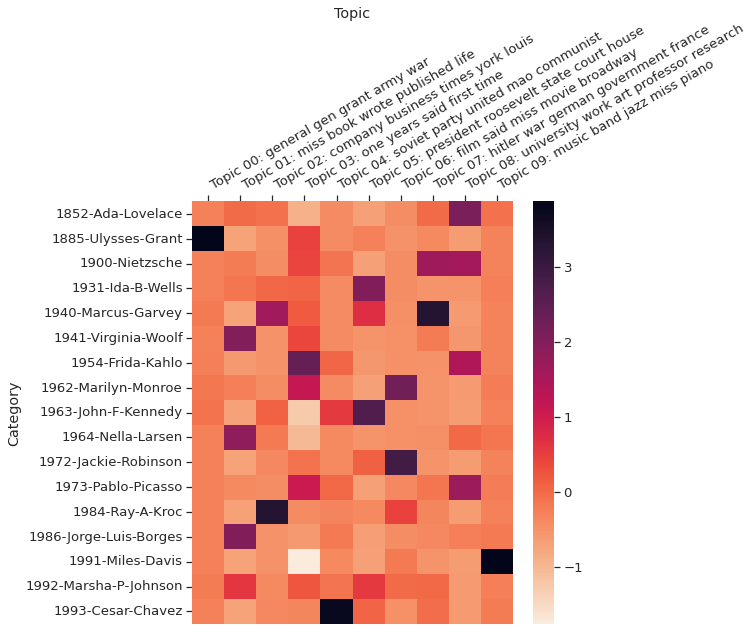

In [28]:
little_mallet_wrapper.plot_categories_by_topics_heatmap(obit_titles,
                                      topic_distributions,
                                      topics, 
                                      output_directory_path + '/categories_by_topics.pdf',
                                      target_labels=target_labels,
                                      dim= (10, 9)
                                     )

The darker squares in this heatmap represent a high probability for the corresponding topic (compared to everyone else in the heatmap) and the lighter squares in the heatmap represent a low probability for the corresponding topic. For example, if you scan across the row of Marilyn Monroe, you can see a dark square for the topic "miss film theater movie theater broadway". If you scan across the row of Ada Lovelace, an English mathematician who is now recognized as the first computer programmer, according to her [NYT obituary](https://www.nytimes.com/interactive/2018/obituaries/overlooked-ada-lovelace.html), you can see a dark square for "university professor research science also".

## Display Top Titles Per Topic

We can also display the obituaries that have the highest probability for every topic with the `little_mallet_wrapper.get_top_docs()` function.

Because most of the obituaries in our corpus are pretty long, however, it will be more useful for us to simply display the title of each obituary, rather than the entire document—at least as a first step. To do so, we'll first need to make two dictionaries, which will allow us to find the corresponding obituary title and the original text from a given training document.

In [29]:
training_data_obit_titles = dict(zip(training_data, obit_titles))
training_data_original_text = dict(zip(training_data, original_texts))

Then we'll make our own function `display_top_titles_per_topic()` that will display the top text titles for every topic. This function accepts a given `topic_number` as well as a desired `number_of_documents` to display.

In [30]:
def display_top_titles_per_topic(topic_number=0, number_of_documents=5):
    
    print(f"✨Topic {topic_number}✨\n\n{topics[topic_number]}\n")

    for probability, document in little_mallet_wrapper.get_top_docs(training_data, topic_distributions, topic_number, n=number_of_documents):
        print(round(probability, 4), training_data_obit_titles[document] + "\n")
    return

**Topic 0**

To display the top 5 obituary titles with the highest probability of containing Topic 0, we will run:

In [31]:
display_top_titles_per_topic(topic_number=0, number_of_documents=5)

✨Topic 0✨

['general', 'gen', 'grant', 'army', 'war', 'israel', 'president', 'military', 'peace', 'men', 'secretary', 'arab', 'pershing', 'command', 'israeli', 'troops', 'upon', 'macarthur', 'forces', 'union']

0.4984 1877-Bedford-Forrest

0.4805 1870-Robert-E-Lee

0.4319 1885-Ulysses-Grant

0.431 1966-Chester-Nimitz

0.4228 1909-Geronimo



**Topic 0 Label**: What label would you give this topic?

ANSWER HERE

**Topic 9**

To display the top 5 obituary titles with the highest probability of containing Topic 9, we will run:

In [32]:
display_top_titles_per_topic(topic_number=9, number_of_documents=5)

✨Topic 9✨

['music', 'band', 'jazz', 'miss', 'piano', 'musical', 'sinatra', 'composer', 'goodman', 'york', 'orchestra', 'new', 'concert', 'stravinsky', 'played', 'dance', 'bernstein', 'armstrong', 'works', 'playing']

0.6612 1983-Earl-Hines

0.622 1993-Dizzy-Gillespie

0.6008 1991-Miles-Davis

0.5706 1993-Carlos-Montoya

0.5428 1986-Benny-Goodman



**Topic 9 Label**: What label would you give this topic?

ANSWER HERE

## Display Topic Words in Context of Original Text

Often it's useful to actually look at the document that has ranked highly for a given topic and puzzle out why it ranks so highly.

To display the original obituary texts that rank highly for a given topic, with the relevant topic words **bolded** for emphasis, we are going to make the function `display_bolded_topic_words_in_context()`.

In the cell below, we're importing two special Jupyter notebook display modules, which will allow us to make the relevant topic words **bolded**, as well as the regular expressions library `re`, which will allow us to find and replace the correct words.

In [33]:
from IPython.display import Markdown, display
import re

def display_bolded_topic_words_in_context(topic_number=3, number_of_documents=3, custom_words=None):

    for probability, document in little_mallet_wrapper.get_top_docs(training_data, topic_distributions, topic_number, n=number_of_documents):
        
        print(f"✨Topic {topic_number}✨\n\n{topics[topic_number]}\n")
        
        probability = f"✨✨✨\n\n**{probability}**"
        obit_title = f"**{training_data_obit_titles[document]}**"
        original_text = training_data_original_text[document]
        topic_words = topics[topic_number]
        topic_words = custom_words if custom_words != None else topic_words

        for word in topic_words:
            if word in original_text:
                original_text = re.sub(f"\\b{word}\\b", f"**{word}**", original_text)

        display(Markdown(probability)), display(Markdown(obit_title)), display(Markdown(original_text))
    return

**Topic 3**

To display the top 3 original obituaries with the highest probability of containing Topic 0 and with relevant topic words bolded, we will run:

In [34]:
display_bolded_topic_words_in_context(topic_number=3, number_of_documents=3)

✨Topic 3✨

['one', 'years', 'said', 'first', 'time', 'new', 'later', 'would', 'made', 'two', 'many', 'world', 'life', 'year', 'man', 'became', 'american', 'could', 'also', 'great']



✨✨✨

**0.7272408469200601**

**1919-C-J-Walker**

May 26, 1919

 OBITUARY

 Wealthiest Negress Dead

 By THE NEW YORK TIMES

 Mrs. C. J. Walker, known as New York's wealthiest negress, having accumulated a fortune from the sale of so-called anti-kink hair tonic and from real estate investments in the last fourteen **years**, died yesterday morning at her country estate at Irvington-on-Hudson.

 She was proprietor of the Madame Walker hair dressing parlors at 108 West 136th Street and other places in the city. Her death recalled the unusual story of how she rose in twelve **years** from a washerwoman making only $1.50 a day to a position of wealth and influence among members of her race.

 Estimates of Mrs. Walker's fortune had run up to $1,000,000. She **said** herself **two** **years** ago that she was not yet a millionaire, but hoped to be some **time**, not that she wanted the money for herself, but for the good she **could** do with it. She spent $10,000 every **year** for the education of young negro men and women in Southern colleges and sent six youths to Tuskegee Institute every **year**. She recently gave $5,000 to the National Conference on

 Lynching.

 Born fifty-**one** **years** ago, she was married at 14, and was left a widow at 20 with a little girl to support. She worked as a cook, washerwoman, and the like until she had reached the age of about 37. One morning while bending over her wash she suddenly realized that there was no prospect on her meager wage of laying away anything for old age.

 She had often **said** that **one** night shortly afterward she had a dream and something told her to start a hair tonic business, which she did, in Denver, Col., on a capital of $1.25.

 In a few **years** she had accumulated a large sum, and invested in real estate in the West and South and in New York State, nearly all the property greatly increasing in value. She then owned a $50,000 home in the northern part of this city, which some **years** ago she gave to her daughter, Mrs. Lelia Walker Robinson, associated with her in business.

 In 1917 Madame Walker completed at Irvington, on the banks of the Hudson, a mansion which cost $250,000, and since then had **made** her home there. The house, which is **one** of the show places in the vicinity, is three stories high and consists of thirty or more rooms. She had installed in this home an $8,000 organ with furnishings, including bronze and marble statuary, cut glass candelabra, tapestries, and paintings, **said** to be of intrinsic beauty and value.

 



✨Topic 3✨

['one', 'years', 'said', 'first', 'time', 'new', 'later', 'would', 'made', 'two', 'many', 'world', 'life', 'year', 'man', 'became', 'american', 'could', 'also', 'great']



✨✨✨

**0.6993520875403538**

**1922-Nellie-Bly**

January 28, 1922

 OBITUARY

 Nellie Bly, Journalist, Dies of Pneumonia

 By THE NEW YORK TIMES

 Mrs. Elizabeth Cochrane Seaman, known to thousands of people throughout the **world** as Nellie Bly, her nom de plume, died yesterday morning of pneumonia at the age of 57 in St. Mark's Hospital, to which she was removed a few days ago from her rooms in the Hotel McAlpin. Services will be held at 2 o'clock tomorrow afternoon at the Church of the Ascension, Fifth Avenue and Tenth Street.

 Friends may view the body today at the funeral parlors of Herbert H. Baxter, 597 Lexington Avenue.

 Born at Cochrane's Mills, Pa., a town founded by her father, Judge Cochrane, Elizabeth Cochrane found herself penniless when still in her teens and began her journalistic career writing for a Pittsburgh paper at $5 a week. Later she reached a high water mark of $25,000 earned with her pen in **one** **year**.

 She went down into the sea in a diving bell and up in the air in a balloon and lived in an insane asylum as a patient; but the feat that **made** her famous was her trip around the **world** in 1889. She was sent by The World to beat the mark of Phileas Fogg, Jules Verne's hero of "Around the World in Eighty Days," and she succeeded, making the tour in 72 days 6 hours 11 minutes. Every **one** who read newspapers followed her progress and she landed in New York a national character.

 In 1895, she married Robert L. Seaman, forty **years** her senior, President of the American Steel Barrel Company and the Ironclad Manufacturing Company. They lived happily together at 15 West Thirty-Seventh

 Street, and on Mr. Seaman's death in 1910 she took entire charge of the properties. Luck turned against her, however, and a series of forgeries by her employees, disputes of various sorts, bankruptcy and a mass of vexations and costly litigations swallowed up Nellie Bly's fortune. Her courage and liveliness remained, however, and she returned to journalism with all her old spirit. At the **time** of her death she was a member of the staff of The New York Evening Journal.

 



✨Topic 3✨

['one', 'years', 'said', 'first', 'time', 'new', 'later', 'would', 'made', 'two', 'many', 'world', 'life', 'year', 'man', 'became', 'american', 'could', 'also', 'great']



✨✨✨

**0.6942232330226512**

**1960-Emily-Post**

September 27, 1960

 OBITUARY

 Emily Post Is Dead Here at 86; Writer was Arbiter of Etiquette

 By THE NEW YORK TIMES

 Mrs. Emily Post, for **many** **years** a leading authority on all matters of social good form, died Sunday in her apartment at 39 East Seventy-ninth Street after a brief illness. Her age was 86.

 In a **time** when **many** believed that good manners were necessarily elaborate, Mrs. Post was a pioneer in simplifying them.

 If you picked up the wrong fork, there was a possibility that your hostess was wrong in having too **many** forks, Mrs. Post taught. It wasn't necessarily you who were wrong. She believed that what was socially right was what was socially simple and unaffected.

 She taught as the basis of all correct deportment that "no **one** should do anything that can either annoy or offend the sensibilities of others." Thousands found their social problems solved by her simple counsels. Her name **became** synonymous with good manners.

 Mrs. Post's advice was varied. She gave suggestions about how to inculcate good manners in an active 7-**year**-old boy and she **could** and did answer complicated questions about the proper way to address titled persons of Europe.

 But for the most part she advised the debutante, the confused suitor and the newly married couple who wished to establish themselves in good relations with the **world** about them. She always avoided giving lonelyhearts advice and never suggested ways to capture a husband or wife, although **many** young persons found courtship easier because of what she **said**.

 When Mrs. Post's **first** widely known book, "Etiquette," was published in 1922, **many** of the existing handbooks of social usage presupposed wealth and elegance on the part of the reader. Mrs. Post offered advice to society as it was and answered basic problems that confront ordinary people who want to have good manners. Every edition of her book emphasized the basic rule of etiquette: make the other person comfortable. The book was revised ten times and was in its eighty-ninth printing.

 For **many** **years** Mrs. Post had a radio program and a daily column, which is still being syndicated to more than 200 newspapers. Her mail was enormous and she had to set up a special office to handle it.

 Chaperones Decline

 It was largely due to Mrs. Post's gentle guidance in the modern frame of mind that the chaperone tended to become a less important feature of society. The duties of the chapeone and, indeed, the very chaperone herself, tended to disappear from **later** editions of Mrs. Post's book. However, when a bachelor girl asked her if it was correct to visit a **man** alone in his apartment, she always **said** no.

 Mrs. Post never **made** capital out of her own social position, which was excellent. She had **first**-hand knowledge of the social **world** at Bar Harbor, Me., where she spent her summers, and she traveled extensively in Europe.

 In addition to establishing herself as a leading authority on good manners, Mrs. Post enjoyed some success as a fiction writer. She wrote a novel, "The Title Market," and her short stories as well as her articles on good social usage appeared in such magazines as Scribners and Colliers.

 She even wrote a cook book, which was widely sold under the title, "The Emily Post Cook Book." Other books by Mrs. Post include "The Personality of a House," "Children Are People," "How to Behave Though a Debutante," "Purple and Fine Linen," "By Motor to the Golden Gate" and "The Eagle's Feather." Her **first** book, "Flight of the Moth," appeared in 1904.

 In 1946 Mrs. Post founded the Emily Post Institute, where problems of gracious living were to be studied. Mrs. Post trained the staff herself.

 Born in Baltimore in 1873, Mrs. Post was a daughter of Bruce and Josephine Lee Price. Her father was an architect. She was educated privately at home and atttended a finishing school in New York, where her family moved when she was 10.

 Mrs. Post was about 5 feet 9 inches tall and had soft gray hair and blue eyes. Her pet dislikes were pretentious people, dirty silver and hostesses who served themselves **first**. She liked terrapin, boiled hominy and strawberry and **could** tell how they should be cooked and served and when each was appropriate in a meal.

 For **many** **years** she spent part of her summers in a 170-**year**-old house in Edgartown, Martha's Vineyard, Mass. She designed the decorations of the house herself and supervised its remodeling.

 Last **year** Mrs. Post wrote a series of columns about motor manners. She had long been appalled by the thoughtlessness of persons driving in traffic and sought to set down a few simple maxims of good manners to take the scowl and snarl out of automobile driving.

 Mrs. Post was the center of a notable contretemps when she spilled a spoonful of berries at a dinner of the Gourmet Society here in 1938. With faultless etiquette, the ninety-**two** members of the society pretended not to notice, and continued eating. The press, perhaps a bit less mannerly, **made** the most of the little faux pas, but Mrs. Post laughed it off.

 Applied Common Sense

 Mrs. Post seldom hesitated to answer a question in her field and often she simply applied common sense to the problem. Once she was called upon to settle the question: Is dunking doughnuts correct?" She answered: "Any place that **would** have doughnuts **would** be like a picnic, where, short of smearing wet doughuts from ear to ear, you **could** do pretty much as you pleased. You wouldn't have doughnuts at a formal dinner anyway."

 Elbows on the table while eating? Mrs. Post **said**: "The rule is against elbows on the table while eating. If not using the arm as a lever swinging a fork or spoon from plate to mouth, it really doesn't make much difference." "Etiquette," she once **said**, "is the science of living. It embraces everything. It is the code of sportsmanship and of honor. It is ethics."

 In 1892 Emily Price was married to Edwin Main Post, a banker, member of a family widely known in social circles on Long Island. This marriage was terminated by divorce. Mr. Post drowned in a sailboat accident in Fire Island Inlet. Two sons, Edwin M. Post

 Jr. and Bruce Price Post were born to this marriage. Bruce Price Post died in 1927. A grandson, William Goadby Post, **also** survives.

 A funeral service will be held Thursday at 10.30 A.M. in St. James Protestant Episcopal Church, Madison Avenue at Seventy-**first** Street. Burial will be private.

 



**Topic 8**

To display the top 3 original obituaries with the highest probability of containing Topic 8 and with relevant topic words bolded, we will run:

In [35]:
display_bolded_topic_words_in_context(topic_number=8, number_of_documents=3)

✨Topic 8✨

['university', 'work', 'art', 'professor', 'research', 'picasso', 'science', 'institute', 'scientific', 'paris', 'modern', 'artist', 'human', 'society', 'oppenheimer', 'world', 'age', 'received', 'also', 'theory']



✨✨✨

**0.5866357058680108**

**1959-Ross-G-Harrison**

October 1, 1959

 OBITUARY

 Ross G. Harrison, Yale Zoologist, 89

 Special to The New York Times

 NEW HAVEN, Sept. 30--retired director of the Osborn Zoological Laboratory of Yale University and a pioneer in the embryonic transplantation and culture of animal tissue outside the organism, died at his home here today. He was 89 years old.

 Dr. Harrison, who was Sterling Professor of Biology Emeritus at Yale, had earned international fame as a zoologist and biologist. He formerly served as chairman of the National Research Council and headed that body from 1938 to 1946.

 In 1907 Dr. Harrison first adopted the hanging drop culture method to the study of embryonic tissues. His observation that the outgrowth of the nerve from the parent cell body demonstrated that the outgrowth was a form of protoplasmic movement settled a long-standing controversy as to the formation and fundamental nature of nerve fibers.

 An outgrowth of the tissue-culture technique was the growth of poliomyelitis virus on monkey kidney cells. The technique was cited in an $8,000 award Dr. Harrison **received** in 1956 from the Academia Nazionale dei Lincei, the oldest of Italy's scholarly national societies.

 Through his successful development of a method of transplanting organs by removing embryonic cells at early stages of development from their normal positions and placing them either in another part of the same embryo or even another embryo it became possible to trace the subsequent development of the particular cells or organ that had been transplanted.

 Dr. Harrison had served for seventeen years as Sterling Professor at Yale. He was born in Germantown, Philadelphia, a son of Samuel and Katherine Diggs Harrison, on Jan. 13, 1870. He was graduated from

 Johns Hopkins University with a Bachelor of Arts degree in 1889 and **received** a Ph.D. there in 1894.

 Five years later he **received** a Doctor of Medicine degree at Bonn University in Germany. He subsequently was granted honorary degrees by Yale, Harvard and Columbia Universities and the Universities of

 Cincinnati, Michigan, Dublin, Chicago, Freiburg and Budapest.

 Dr. Harrison began his teaching career at Bryn Mawr College as a lecturer in morphology in 1894.

 For many years Dr. Harrison, who wrote numerous papers in his fields of study, was the editor of The Journal of Experimental Zoology. He served **also** as a trustee of the Marine Biological Laboratory at

 Woods Hole, Mass., and the Bermuda Biological Station.

 Surviving Dr. Harrison are his widow, the former Ida Lange; three daughters, Miss Dorothea Harrison of Concord, Mass; Dr. Elizabeth Ross Harrison, a New Haven pediatrician, and Mrs. Rufus Putney of Boulder,

 Col.; two sons, Ross Granville Harrison Jr., of Darien, Conn., and Richard Edes Harrison of New York; seven grandchildren and one great-grandchild.

 



✨Topic 8✨

['university', 'work', 'art', 'professor', 'research', 'picasso', 'science', 'institute', 'scientific', 'paris', 'modern', 'artist', 'human', 'society', 'oppenheimer', 'world', 'age', 'received', 'also', 'theory']



✨✨✨

**0.5830294970064629**

**1950-A-J-Dempster**

March 12, 1950

 OBITUARY

 Dr. A. J. Dempster, Physicist, 63, Dead

 Special to THE NEW YORK TIMES

 CHICAGO, March 11--Dr. Arthur J. Dempster, Professor of Physics at the University of Chicago and discoverer of uranium 235, an essential element of the atomic bomb, died today of a heart attack in Stuart, Fla., where he was spending a vacation. He was 63 years old.

 An authority on mass spectroscopy and on the relative stability of the nuclei of atoms, Dr. Dempster was internationally known for his experiments establishing the large release of energy in the fission of uranium.

 His early **work** was in the study of isotopes, on which he made the first quantitative study of atomic weight. Regarded as the principal authority on positive rays, he made extensive studies that brought about the discovery that protons go through helium without being appreciably deflected.

 Dr. Dempster discovered that the protons of a hydrogen atom have wave characteristics and that they vibrate at 1,000,000 times the frequency of light waves. This frequency was comparable to that of cosmic rays, although the wave form was different.

 He had been a member of the University of Chicago faculty since 1917, and had been a full **professor** since 1927. He was elected to the National Academy of Sciences, and won the $1,000 award of the American Association for the Advancement of Science and the Lewis award of the American Philosophical Society.

 Dr. Dempster, who **received** a doctorate from the University of Chicago in 1916, had taken Bachelor's and Master's degrees at the University of Toronto in 1909 and 1910, respectively. The University of Toronto awarded to him an honorary Doctor of Philosophy degree in 1937.

 In the first World War, Dr. Dempster served with the Army Signal Corps as an expert on wireless telegraphy.

 He leaves his wife, Mrs. Germaine Colette Dempster, who was with him at his death. They had no children.

 



✨Topic 8✨

['university', 'work', 'art', 'professor', 'research', 'picasso', 'science', 'institute', 'scientific', 'paris', 'modern', 'artist', 'human', 'society', 'oppenheimer', 'world', 'age', 'received', 'also', 'theory']



✨✨✨

**0.5769945310499387**

**1967-Gregory-Pincus**

August 23, 1967

 OBITUARY

 Dr. Pincus, Developer of Birth-Control Pill, Dies

 Special to The New York Times

 BOSTON, Aug. 22--Dr. Gregory Goodwin Pincus, one of the three "fathers" of the birth-control pill, died here tonight at Peter Bent Brigham Hospital of myeloid metaplasia, a rare blood disease. He was 64 years old and lived in Northboro.

 Expert on Reproduction

 With Dr. M. C. Chang, a senior scientist of the Worcester Foundation, and Dr. John Rock, head of the Rock Reproductive Clinic of Brookline, Mass., Dr. Pincus developed a relatively safe and simple oral contraceptive that revolutionized family planning.

 The Pill, as it has come to be called, not only revolutionized methods of birth control, but **also** introduced the previously taboo topic as a subject for worldwide debate on curbing overpopulation.

 Women were cautious in accepting it when it was first marketed in 1960 but today more than six million American women--nearly one-fifth of those of childbearing **age**--are believed to be using it--and the number is growing.

 Dr. Pincus was **research** director of the Worcester Foundation for Experimental Biology, and his interest included many aspects of hormone studies. He was an authority in mammalian reproduction and a pioneer in cancer **research**.

 Studied Adrenal Hormone

 In the late nineteen-forties Dr. Pincus focused his attention on the role of hormones in his study of reproduction. With a grant from the National Institute of Arthritis and Metabolic Diseases of the Public Health Service in the fifties, he began a study of the properties of hydrocortisone, an adrenal hormone.

 These experiments involved the use of progesterone, a female hormone secretion that is triggered by ovulation. The hormone thickens the walls of the Fallopian tubes and the womb in preparation for the fertilized egg. Progesterone **also** safeguards against overlapping pregnancies by preventing further fertilization and thus serves as a natural birth-control agent.

 Dr. Pincus and Dr. Chang began to discuss the possibility of a synthetic progesterone. They experimented with more than 200 substances before settling upon three steroid compounds derived from the roots of the wild Mexican yam. These seemed to prevent ovulation in laboratory animals.

 It was at this time that the two biologists teamed up with Dr. Rock, a Roman Catholic gynecologist and obstetrician, who was **also** working with progesterone to cure infertility in his childless patients.

 Dr. Chang made the basic experimental observations, while Dr. Pincus worked the findings into the over-all **research** scheme. "Pincus can interrupt a critical problem to take 10 phone calls and then switch his mind back to the problem in a second," an associate said. "Recognizing people and **human** frailties as they exist, he has freed himself from emotional turbulence."

 Tested in 3 Areas

 In 1956, Dr. Pincus began experiments in Brookline, Mass., Puerto Rico and Haiti with the steroids in pill form on hundreds of women. Again success was reported. In 1957 the Food and Drug Administration authorized the marketing of the steroids for miscarriage and certain menstrual disorders, and in 1960, the Federal agency licensed Enovid, a contraceptive pill.

 The pill is believed to be 100 per cent effective, and the very few pregnancies that have been reported among pill-users are believed to be errors in negligence in remembering to take the pill.

 The pill is taken daily for 20 days, during which time ovulation is impossible. The egg, instead of being released and passed into the Fallopian tubes, where fertilization could take place, is simply reabsorbed within the ovary. Within five days after the pills are stopped the woman begins to menstruate again. On the fifth day of menstruation, the next 20-day pill cycle is begun.

 Dr. Chang and Dr. Pincus had been working recently on a new pill, known popularly as the "morning-after" pill. It affects the egg after ovulation. During the seven days or more required for the fertilized egg to become implanted in the uterus, the pill expels the egg from the Fallopian tubes and uterus before implantation can occur.

 Dr. Pincus was **also** credited with the development of Estrone, a hormone used in the treatment of breast cancer and pregnancy complications.

 Dr. Pincus, a bushy-haired man with a gray mustache and dark, burning eyes, was born in Woodbine, N. J., on April 9, 1903, and later credited two uncles, both agricultural scientists, as responsible for his early interest in **research**. "As long as I can remember, I knew I was going to be a scientist," he once recalled. He went to Cornell and **received** a bachelor's degree in agriculture in 1924. Then he went to Harvard where he was an instructor in zoology while **also** working toward his master's and doctorate degrees.

 From 1927 to 1930 he moved from Harvard to Cambridge University in England to the Kaiser Wilhelm Institute in Berlin, conducting **research**. He became an instructor in general physiology at Harvard in 1930 and was promoted a year later to assistant **professor**.

 By 1938, at the **age** of 35, he was already an international authority on the sex of mammals and sex hormones, and more than 70 of his **research** papers had been published.

 Dr. Pincus became known to the general public when newspapers printed articles about his experiments and **research** with "fatherless" rabbits.

 In 1939, while a **professor** of experimental zoology at Clark University in Worchester, Mass., he brought about the first fatherless mammalian birth in history by inducing parthenogenesis in a female rabbit. He used high temperature, hormone treatments and salt solutions to fertilize the ovum in a test tube.

 He then implanted the developing egg in the reproductive tract of the female rabbit, where the egg matured through the normal stages.

 But the **research** **also** caused him prolonged embarrassment. In May of that year, he went to Toronto to report on his experiments to a meeting of the Federation of American Societies for Experimental Biology.

 He said emphatically that he was not planning to carry on his experiments with rabbits to see if **human** babies could be made by test-tube method. But a report of his remarks omitted the word "not," and he was thereafter called upon frequently, both here and abroad, to deny that he was trying "to create **human** life in the laboratory."

 The Worcester Foundation had been created the previous year, and Dr. Pincus and Dr. Hoagland interested local businessmen and professionals in raising funds to purchase a 12-acre estate at Shrewsbury, Mass., where the foundation's main buildings are now located.

 The foundation was formally incorporated in 1944, with Dr. Pincus as a co-director. The 20th anniversary report indicated some of the scope of the foundation's activities: **research** in the fields of steroids, cancer **research**, studies of the **human** aging process, possible chemical causes of schizophrenia and other mental diseases and the relationship of hormones to heart disease.

 In 1940, he was asked what he saw in the future on the basis of his early experiments. "I can't tell," he replied, "but there are no big steps, there are all little steps. We have to follow processes systematically. The big questions are: why does an egg start to develop and why does it continue to develop."

 Concurrent with his **work** at the foundation, Dr. Pincus served as **research** **professor** at the Tufts College Medical School from 1946 to 1950 and as **research** **professor** in biology at Boston University from 1950 until his death.

 The **work** of the foundation attracted eminent scientists from all parts of the **world**. More than 300 scientists from 40 countries are currently involved in foundation **research**.

 Cited Many Times

 Dr. Pincus was a member or chairman of many important **research** committees of the National Institute of Health of the United States Public Health Service and **also** of the National Research Council.

 He was the recipient of numerous prizes and awards, including the Albert D. Lasker Award in Planned Parenthood, 1960; the Modern Medicine Award for Distinguished Achievement in 1964; and the American Medical Association Scientific Achievement Award in 1967.

 His books included "The Eggs of Mammals," published in 1936, and "The Control of Fertility," published in 1965.

 Dr. Pincus is survived by his widow, the former Elizabeth Notkin, whom he married in 1924; a son, John; a daughter, Mrs. Laura Bernard; three brothers, Lee, Maurice, and Alexis; a sister, Mrs. Charles O. Dutton, and four grandchildren.

 A funeral service will be held on Friday at 11 A.M. at Temple Emanuel, Chandler Street, Worcester. Burial will be private.

 



## Your Turn!

Choose a topic from the results above and write down its corresponding topic number below.

**Topic: *Your Number Choice Here***

**1.** Display the top 6 obituary titles for this topic.

In [ ]:
#Your Code Here

**2.** Display the topic words in the context of the original obituary for these 6 top titles.

In [ ]:
#Your Code Here

**3.** Come up with a label for your topic and write it below:

**Topic Label: *Your Label Here***

**Reflection**

**4.** Why did you label your topic the way you did? What do you think this topic means in the context of all the *NYT* obituaries?

**#**Your answer here

**5.** What's another collection of texts that you think might be interesting to topic model? Why?

**#**Your answer here

## BONUS

If you want to explore further, try returning to the top and replacing the obituaries with the lyrics corpus and/or changing the number of topics from 15 to other numbers.